# Understanding LLM Token Probabilities: A Practical Guide

## Environment Setup
Quick OpenAI connection to submit prompts and return logprobs for our analysis.

In [1]:
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

# Set up plotting style
plt.style.use('default')
sns.set_palette("viridis")

print("Environment ready!")
print(f"OpenAI version: {openai.__version__}")

Environment ready!
OpenAI version: 1.91.0


## API Connection and Test Function
Just a quick sanity check so we know our keys work and the API is connecting as expected (easier to troubleshoot here than later!)

In [2]:
# Load API key from config
with open('config.json', 'r') as f:
    config = json.load(f)

client = openai.OpenAI(
    api_key=config['openai_api_key']
)

# Test function using Chat Completions with logprobs
def get_completion_with_logprobs(prompt, temperature=0.7, max_tokens=10):
    """Get completion with token probabilities using Chat Completions API"""
    response = client.chat.completions.create(
        model="gpt-4.1",  # Latest and best model
        messages=[{"role": "user", "content": prompt}],
        max_tokens=max_tokens,
        temperature=temperature,
        logprobs=True,
        top_logprobs=5  # top 5 token probabilities
    )
    return response

# Test with our simple example
test_prompt = "The capital of France is"
print(f"Testing with: '{test_prompt}'")

Testing with: 'The capital of France is'


## Exploring Response Structure
The OpenAI API returns probabilities for each token - this is simple view to show and explore the data returned and how a simple prompt/response looks along side of these probability data

In [3]:
# Make a test call to see the response structure
response = get_completion_with_logprobs(test_prompt, temperature=0.7, max_tokens=10)

print("=== RESPONSE STRUCTURE ===")
print(f"Model used: {response.model}")
print(f"Total tokens: {response.usage.total_tokens}")
print(f"Generated text: '{response.choices[0].message.content}'")

print("\n=== LOGPROBS STRUCTURE ===")
logprobs_data = response.choices[0].logprobs
print(f"Logprobs type: {type(logprobs_data)}")

if logprobs_data and logprobs_data.content:
    print(f"Number of tokens: {len(logprobs_data.content)}")
    print("\nFirst token details:")
    first_token = logprobs_data.content[0]
    print(f"  Token: '{first_token.token}'")
    print(f"  Logprob: {first_token.logprob}")
    print(f"  Probability: {np.exp(first_token.logprob):.4f}")
    
    print(f"\nTop alternatives for first token:")
    for alt in first_token.top_logprobs:
        prob = np.exp(alt.logprob)
        print(f"  '{alt.token}': {prob:.4f}")

=== RESPONSE STRUCTURE ===
Model used: gpt-4.1-2025-04-14
Total tokens: 21
Generated text: 'The capital of France is **Paris**.'

=== LOGPROBS STRUCTURE ===
Logprobs type: <class 'openai.types.chat.chat_completion.ChoiceLogprobs'>
Number of tokens: 9

First token details:
  Token: 'The'
  Logprob: -9.088346359931165e-07
  Probability: 1.0000

Top alternatives for first token:
  'The': 1.0000
  '**': 0.0000
  'Paris': 0.0000
  'the': 0.0000
  ' The': 0.0000


## Token Data Extraction
A more detailed view of the OpenAI probability data

In [4]:
def extract_token_data(response):
    """Extract tokens and their probabilities from the response"""
    tokens = []
    probabilities = []
    
    if response.choices[0].logprobs and response.choices[0].logprobs.content:
        for token_data in response.choices[0].logprobs.content:
            tokens.append(token_data.token)
            # Convert log probability to regular probability
            prob = np.exp(token_data.logprob)
            probabilities.append(prob)
    
    return tokens, probabilities

# Test our extraction function
tokens, probs = extract_token_data(response)

print("=== EXTRACTED TOKEN DATA ===")
for i, (token, prob) in enumerate(zip(tokens, probs)):
    print(f"Token {i}: '{token}' -> {prob:.4f}")

print(f"\nFull text: {''.join(tokens)}")
print(f"Confidence range: {min(probs):.4f} to {max(probs):.4f}")

=== EXTRACTED TOKEN DATA ===
Token 0: 'The' -> 1.0000
Token 1: ' capital' -> 1.0000
Token 2: ' of' -> 1.0000
Token 3: ' France' -> 1.0000
Token 4: ' is' -> 1.0000
Token 5: ' **' -> 0.9859
Token 6: 'Paris' -> 1.0000
Token 7: '**' -> 1.0000
Token 8: '.' -> 1.0000

Full text: The capital of France is **Paris**.
Confidence range: 0.9859 to 1.0000


## Basic Token Confidence Visualization
This is where the notebooks start to get interesting as the visualization of the tokens and probability start to show where a model is less or more sure of the output being generated.

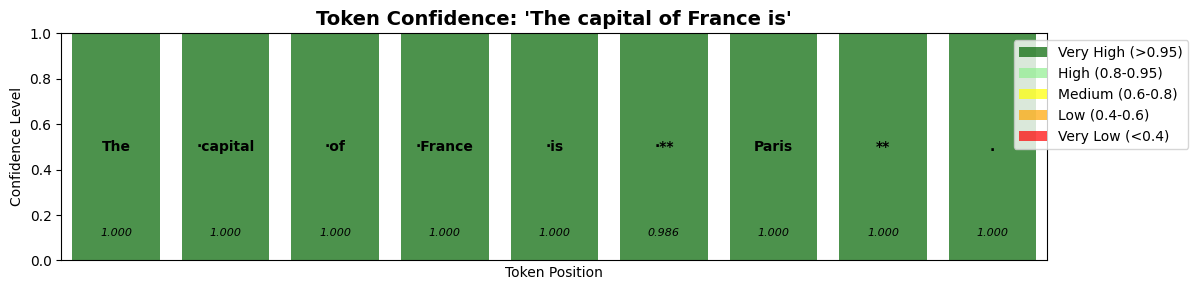

In [5]:
def visualize_token_probabilities(tokens, probabilities, title="Token Probabilities"):
    """Create a heat map visualization of token probabilities"""
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 3))
    
    # Create a colormap - we'll use a color scale where:
    # Low confidence = red, Medium = yellow, High confidence = green
    colors = []
    for prob in probabilities:
        if prob > 0.95:
            colors.append('darkgreen')
        elif prob > 0.8:
            colors.append('lightgreen') 
        elif prob > 0.6:
            colors.append('yellow')
        elif prob > 0.4:
            colors.append('orange')
        else:
            colors.append('red')
    
    # Create the visualization
    bars = ax.bar(range(len(tokens)), [1]*len(tokens), color=colors, alpha=0.7)
    
    # Add token text on each bar
    for i, (token, prob) in enumerate(zip(tokens, probabilities)):
        # Clean up token display (remove extra spaces for readability)
        display_token = token.replace(' ', '·') if token.startswith(' ') else token
        ax.text(i, 0.5, display_token, ha='center', va='center', 
                fontweight='bold', fontsize=10)
        ax.text(i, 0.1, f'{prob:.3f}', ha='center', va='bottom', 
                fontsize=8, style='italic')
    
    # Formatting
    ax.set_xlim(-0.5, len(tokens)-0.5)
    ax.set_ylim(0, 1)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Token Position')
    ax.set_ylabel('Confidence Level')
    ax.set_xticks([])
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='darkgreen', alpha=0.7, label='Very High (>0.95)'),
        Patch(facecolor='lightgreen', alpha=0.7, label='High (0.8-0.95)'),
        Patch(facecolor='yellow', alpha=0.7, label='Medium (0.6-0.8)'),
        Patch(facecolor='orange', alpha=0.7, label='Low (0.4-0.6)'),
        Patch(facecolor='red', alpha=0.7, label='Very Low (<0.4)')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    plt.show()

# Test our visualization
visualize_token_probabilities(tokens, probs, "Token Confidence: 'The capital of France is'")

## Temperature Effects on Simple Prompts
**Temperature controls randomness.**  
Lower = more predictable. Higher = more creative or chaotic.

So:
- `temperature = 0` → safest, most deterministic  
- `temperature = 1` → creative, varied, less consistent  

*Think of it like turning up or down the “risk” dial.*

In [6]:
# Test the same prompt at different temperatures
temperatures = [0.1, 0.7, 1.2]
temp_results = {}

print("=== TEMPERATURE COMPARISON ===")
for temp in temperatures:
    print(f"\nTesting temperature: {temp}")
    response = get_completion_with_logprobs(test_prompt, temperature=temp, max_tokens=10)
    tokens, probs = extract_token_data(response)
    temp_results[temp] = (tokens, probs)
    
    print(f"Generated: {''.join(tokens)}")
    print(f"Avg confidence: {np.mean(probs):.4f}")
    print(f"Min confidence: {min(probs):.4f}")

=== TEMPERATURE COMPARISON ===

Testing temperature: 0.1
Generated: The capital of France is **Paris**.
Avg confidence: 0.9988
Min confidence: 0.9890

Testing temperature: 0.7
Generated: The capital of France is **Paris**.
Avg confidence: 0.9995
Min confidence: 0.9959

Testing temperature: 1.2
Generated: The capital of France is **Paris**.
Avg confidence: 0.9995
Min confidence: 0.9959


## Creative Prompts: Where Temperature Matters

In [7]:
# Try a prompt where there are multiple valid responses
creative_prompt = "The best programming language for beginners is"

print("=== CREATIVE PROMPT TEMPERATURE COMPARISON ===")
creative_results = {}

for temp in temperatures:
    print(f"\nTemperature {temp}:")
    response = get_completion_with_logprobs(creative_prompt, temperature=temp, max_tokens=15)
    tokens, probs = extract_token_data(response)
    creative_results[temp] = (tokens, probs)
    
    print(f"Generated: {''.join(tokens)}")
    print(f"Avg confidence: {np.mean(probs):.4f}")
    print(f"Min confidence: {min(probs):.4f}")
    print(f"Std dev of confidence: {np.std(probs):.4f}")

=== CREATIVE PROMPT TEMPERATURE COMPARISON ===

Temperature 0.1:
Generated: The best programming language for beginners is **Python**.

**Why Python?
Avg confidence: 0.8340
Min confidence: 0.4058
Std dev of confidence: 0.2036

Temperature 0.7:
Generated: The best programming language for beginners **depends on your goals and interests**, but
Avg confidence: 0.7887
Min confidence: 0.2944
Std dev of confidence: 0.2494

Temperature 1.2:
Generated: The **best programming language for beginners** depends on your goals, interests,
Avg confidence: 0.8189
Min confidence: 0.3137
Std dev of confidence: 0.2435


## Forcing Variability with Constraints

In [8]:
# Focus on prompts that actually showed variability
variable_prompts = [
    "Answer with one word. Subjective is not a valid response, answer the question directly. The best vacation destination is:",
    "Answer one word. Subjective is not a valid response, answer the question directly. The best astrological sign is:"
]

print("=== PROMPTS WITH TEMPERATURE VARIABILITY ===")

for i, prompt in enumerate(variable_prompts):
    print(f"\n{'='*60}")
    print(f"PROMPT {i+1}: '{prompt}'")
    print('='*60)
    
    for temp in [0.2, 0.8, 1.5]:
        print(f"\nTemp {temp}:")
        response = get_completion_with_logprobs(prompt, temperature=temp, max_tokens=10)
        tokens, probs = extract_token_data(response)
        
        print(f"  Generated: {''.join(tokens)}")
        if len(probs) > 0:
            print(f"  First token: '{tokens[0]}' (confidence: {probs[0]:.4f})")
            print(f"  All confidences: {[f'{p:.3f}' for p in probs]}")

=== PROMPTS WITH TEMPERATURE VARIABILITY ===

PROMPT 1: 'Answer with one word. Subjective is not a valid response, answer the question directly. The best vacation destination is:'

Temp 0.2:
  Generated: Japan
  First token: 'Japan' (confidence: 0.4912)
  All confidences: ['0.491']

Temp 0.8:
  Generated: Japan
  First token: 'Japan' (confidence: 0.3025)
  All confidences: ['0.303']

Temp 1.5:
  Generated: Maldives
  First token: 'Mal' (confidence: 0.0506)
  All confidences: ['0.051', '1.000']

PROMPT 2: 'Answer one word. Subjective is not a valid response, answer the question directly. The best astrological sign is:'

Temp 0.2:
  Generated: Leo
  First token: 'Leo' (confidence: 0.9009)
  All confidences: ['0.901']

Temp 0.8:
  Generated: Leo
  First token: 'Leo' (confidence: 0.9009)
  All confidences: ['0.901']

Temp 1.5:
  Generated: Libra
  First token: 'Lib' (confidence: 0.0740)
  All confidences: ['0.074', '1.000']


## Structured JSON Output Analysis
**This cell is where agentic behavior hits home.**

With newer foundation models like ChatGPT-4x+ and simple prompts, you often have to *push* to get misaligned output.  
However, when **prompt complexity** increases and/or **output complexity** increases (e.g., multiple tool calls, structured JSON, etc.),  
this example highlights a key truth:

> **Structure will yield.**


In [9]:
# Test structured JSON output at temperature extremes
json_prompt = """Generate a simple JSON response for an AI agent. Use this exact format:
{
  "action_type": "search",
  "agent_message": "brief message", 
  "expected_response": "what you expect back"
}

Create a JSON for a web search task."""

# Test at extreme temperature ranges
temperatures = [0.1, 1.0, 1.9]  # Low, medium, high

print("=== AGENTIC JSON OUTPUT AT DIFFERENT TEMPERATURES ===")

json_results = {}

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"TEMPERATURE: {temp}")
    print('='*50)
    
    response = get_completion_with_logprobs(json_prompt, temperature=temp, max_tokens=50)
    tokens, probs = extract_token_data(response)
    json_results[temp] = (tokens, probs)
    
    print(f"Generated JSON:")
    print(''.join(tokens))
    print(f"\nConfidence stats:")
    print(f"  Average: {np.mean(probs):.4f}")
    print(f"  Minimum: {min(probs):.4f}")
    print(f"  Std dev: {np.std(probs):.4f}")
    
    # Find the least confident tokens
    min_indices = np.argsort(probs)[:3]  # 3 least confident
    print(f"  Least confident tokens:")
    for idx in min_indices:
        print(f"    '{tokens[idx]}': {probs[idx]:.4f}")

=== AGENTIC JSON OUTPUT AT DIFFERENT TEMPERATURES ===

TEMPERATURE: 0.1
Generated JSON:
{
  "action_type": "search",
  "agent_message": "Searching the web for the latest news headlines.",
  "expected_response": "A list of recent news headlines with brief summaries and source links."
}

Confidence stats:
  Average: 0.9429
  Minimum: 0.3489
  Std dev: 0.1432
  Least confident tokens:
    ' brief': 0.3489
    ' recent': 0.4633
    ' source': 0.5007

TEMPERATURE: 1.0
Generated JSON:
{
  "action_type": "search",
  "agent_message": "Searching the web for the latest news headlines.",
  "expected_response": "A list of recent news headlines with brief summaries and links to sources."
}

Confidence stats:
  Average: 0.8995
  Minimum: 0.2169
  Std dev: 0.2210
  Least confident tokens:
    ' links': 0.2169
    ' to': 0.2451
    ' sources': 0.2623

TEMPERATURE: 1.9
Generated JSON:
{
  "action_type": "search",
  "agent_message": "Searching the web for recent news articles related to renewable energy

## Advanced JSON Visualization
**This visualization highlights where the LLM’s probability or confidence breaks down with conflicting guidance.**

Clear and concise prompts are key.

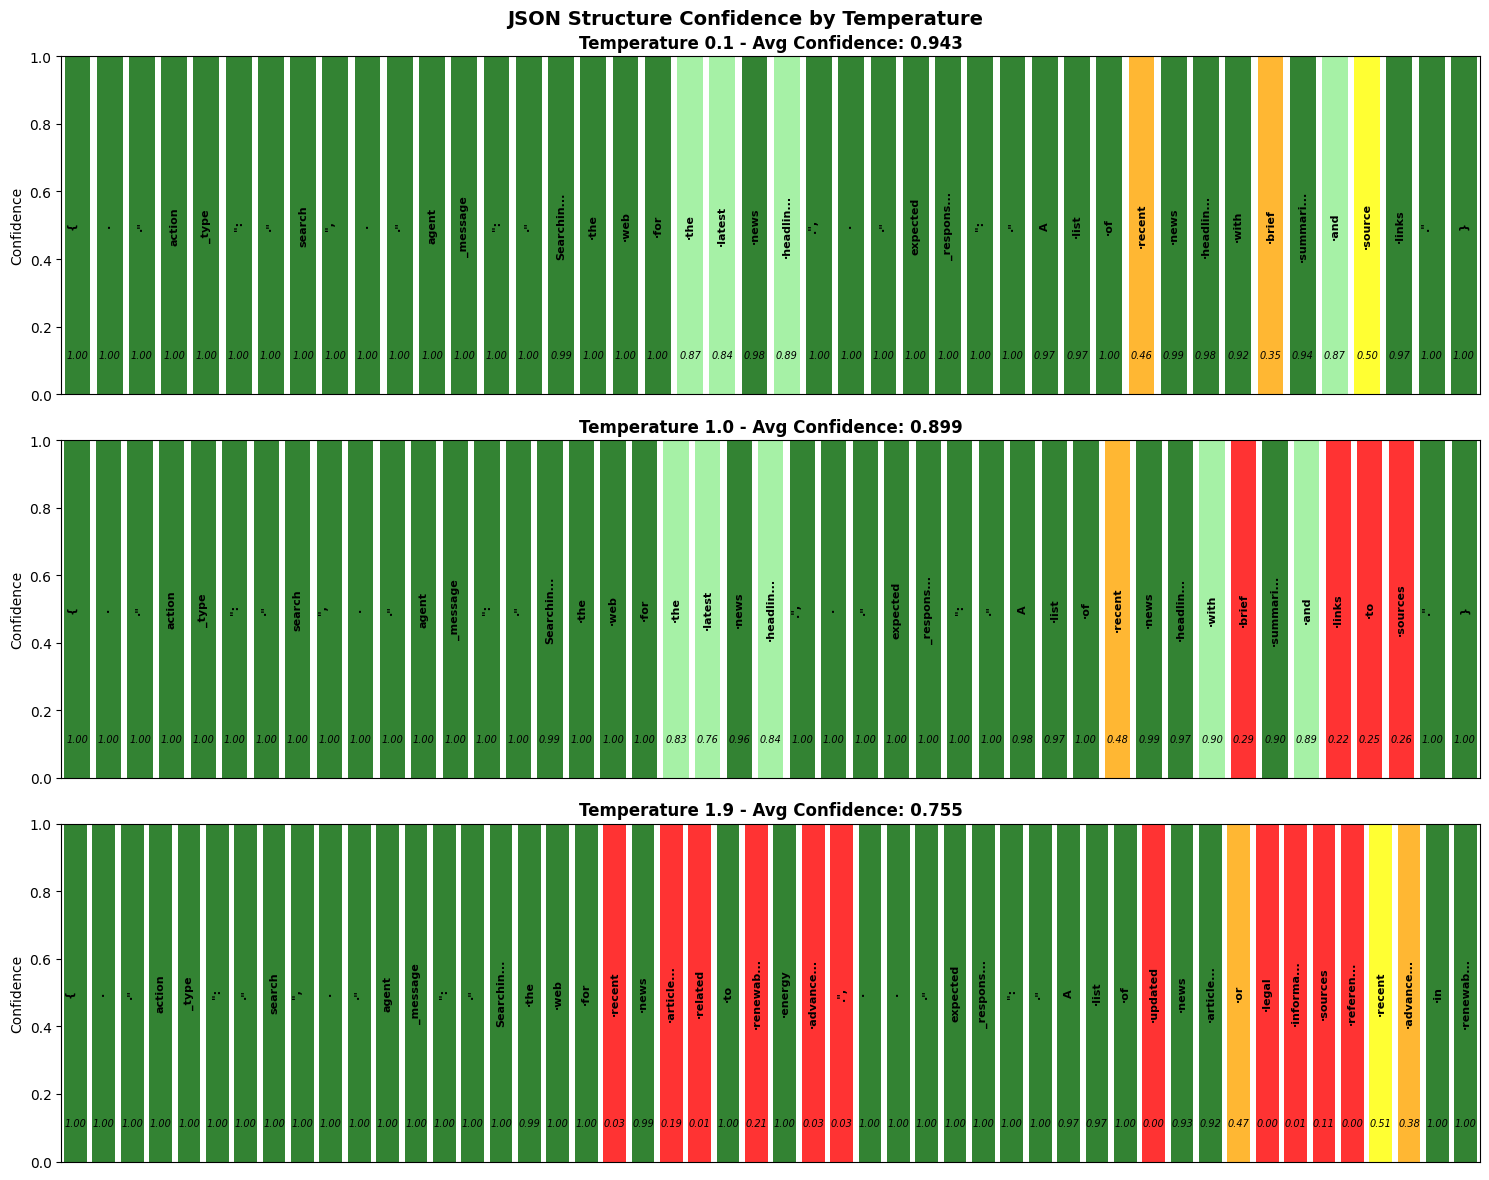

In [18]:
# Create comparison visualization for JSON outputs at different temperatures
def visualize_json_comparison(temp_results, title="JSON Confidence Across Temperatures"):
    """Visualize token confidence for JSON outputs at different temperatures"""
    
    fig, axes = plt.subplots(len(temp_results), 1, figsize=(15, 4*len(temp_results)))
    if len(temp_results) == 1:
        axes = [axes]
    
    for i, (temp, (tokens, probs)) in enumerate(temp_results.items()):
        ax = axes[i]
        
        # Color coding based on confidence
        colors = []
        for prob in probs:
            if prob > 0.9:
                colors.append('darkgreen')
            elif prob > 0.7:
                colors.append('lightgreen') 
            elif prob > 0.5:
                colors.append('yellow')
            elif prob > 0.3:
                colors.append('orange')
            else:
                colors.append('red')
        
        # Create bars
        bars = ax.bar(range(len(tokens)), [1]*len(tokens), color=colors, alpha=0.8)
        
        # Add token text and probabilities
        for j, (token, prob) in enumerate(zip(tokens, probs)):
            # Clean display
            display_token = token.replace(' ', '·') if token.startswith(' ') else token
            if len(display_token) > 8:  # Truncate long tokens
                display_token = display_token[:8] + '...'
                
            ax.text(j, 0.5, display_token, ha='center', va='center', 
                    fontweight='bold', fontsize=8, rotation=90)
            ax.text(j, 0.1, f'{prob:.2f}', ha='center', va='bottom', 
                    fontsize=7, style='italic')
        
        # Formatting
        ax.set_xlim(-0.5, len(tokens)-0.5)
        ax.set_ylim(0, 1)
        ax.set_title(f'Temperature {temp} - Avg Confidence: {np.mean(probs):.3f}', 
                     fontsize=12, fontweight='bold')
        ax.set_ylabel('Confidence')
        ax.set_xticks([])
    
    plt.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Visualize our JSON results
visualize_json_comparison(json_results, "JSON Structure Confidence by Temperature")

## Content Ambiguity in Structured Responses


In [19]:
# Create a prompt where the JSON structure is clear but content choices are ambiguous
ambiguous_json_prompt = """Generate a JSON response for this scenario: A user asks "I'm feeling down, what should I do?" 

Use this exact format:
{
  "action_type": "recommendation",
  "agent_message": "suggestion for the user", 
  "expected_response": "user reaction"
}

There are many valid approaches - pick one."""

# Test at extreme temperature ranges
temperatures = [0.1, 1.0, 1.9]

print("=== AMBIGUOUS JSON CONTENT AT DIFFERENT TEMPERATURES ===")

ambiguous_results = {}

for temp in temperatures:
    print(f"\n{'='*50}")
    print(f"TEMPERATURE: {temp}")
    print('='*50)
    
    response = get_completion_with_logprobs(ambiguous_json_prompt, temperature=temp, max_tokens=60)
    tokens, probs = extract_token_data(response)
    ambiguous_results[temp] = (tokens, probs)
    
    print(f"Generated JSON:")
    print(''.join(tokens))
    print(f"\nConfidence stats:")
    print(f"  Average: {np.mean(probs):.4f}")
    print(f"  Minimum: {min(probs):.4f}")
    print(f"  Std dev: {np.std(probs):.4f}")

=== AMBIGUOUS JSON CONTENT AT DIFFERENT TEMPERATURES ===

TEMPERATURE: 0.1
Generated JSON:
{
  "action_type": "recommendation",
  "agent_message": "I'm sorry you're feeling down. Sometimes it helps to talk to a friend, go for a walk, or do something you enjoy. Would you like some more ideas or resources?",
  "expected_response": "Thanks, I

Confidence stats:
  Average: 0.8756
  Minimum: 0.4116
  Std dev: 0.1776

TEMPERATURE: 1.0
Generated JSON:
{
  "action_type": "recommendation",
  "agent_message": "I'm sorry you're feeling down. Sometimes talking to a friend, taking a short walk, or doing something you enjoy can help lift your mood. If these feelings persist, consider reaching out to a mental health professional.",
  "

Confidence stats:
  Average: 0.9060
  Minimum: 0.4472
  Std dev: 0.1553

TEMPERATURE: 1.9
Generated JSON:
{
  "action_type": "recommendation",
  "agent_message": "I'm sorry to hear you're feeling down. Sometimes it helps to talk to a friend, go for a short walk, or ta

## Mixed Format Testing

In [20]:
# Simpler prompt, more tokens to capture failures
mixed_format_prompt = """User: "What's the weather like?"

Respond with weather info, then "---JSON---" then JSON:
{"query": "weather", "status": "completed"}"""

temperatures = [0.3, 1.2, 1.9]

print("=== SIMPLE MIXED FORMAT: TEXT + SEPARATOR + JSON ===")

mixed_results = {}

for temp in temperatures:
    print(f"\n{'='*60}")
    print(f"TEMPERATURE: {temp}")
    print('='*60)
    
    response = get_completion_with_logprobs(mixed_format_prompt, temperature=temp, max_tokens=300)  # Much more generous
    tokens, probs = extract_token_data(response)
    mixed_results[temp] = (tokens, probs)
    
    full_text = ''.join(tokens)
    print(f"Generated response:")
    print(full_text)
    print(f"[END OF RESPONSE - Length: {len(full_text)} chars]")
    
    # Check separator placement
    if "---JSON---" in full_text:
        parts = full_text.split("---JSON---")
        print(f"\n✅ Separator found. Parts: {len(parts)}")
        if len(parts) == 2:
            json_part = parts[1].strip()
            print(f"JSON part: '{json_part}'")
            try:
                import json
                json.loads(json_part)
                print("✅ JSON valid")
            except Exception as e:
                print(f"❌ JSON invalid: {e}")
    else:
        print("❌ No separator found!")
    
    print(f"\nConfidence: Avg {np.mean(probs):.4f}, Min {min(probs):.4f}, Std {np.std(probs):.4f}")

=== SIMPLE MIXED FORMAT: TEXT + SEPARATOR + JSON ===

TEMPERATURE: 0.3
Generated response:
Currently, I don't have access to real-time weather data. Please check a reliable weather website or app for the most up-to-date information.

---JSON---
{"query": "weather", "status": "completed"}
[END OF RESPONSE - Length: 197 chars]

✅ Separator found. Parts: 2
JSON part: '{"query": "weather", "status": "completed"}'
✅ JSON valid

Confidence: Avg 0.8840, Min 0.3097, Std 0.1903

TEMPERATURE: 1.2
Generated response:
Today's weather varies by location, but in general, expect partly cloudy skies with mild temperatures. If you let me know your city or region, I can provide a more detailed forecast.

---JSON---
{"query": "weather", "status": "completed"}
[END OF RESPONSE - Length: 238 chars]

✅ Separator found. Parts: 2
JSON part: '{"query": "weather", "status": "completed"}'
✅ JSON valid

Confidence: Avg 0.7877, Min 0.0241, Std 0.3316

TEMPERATURE: 1.9
Generated response:
Currently, I don't have ac

# Viaualization of JSON Content Probability

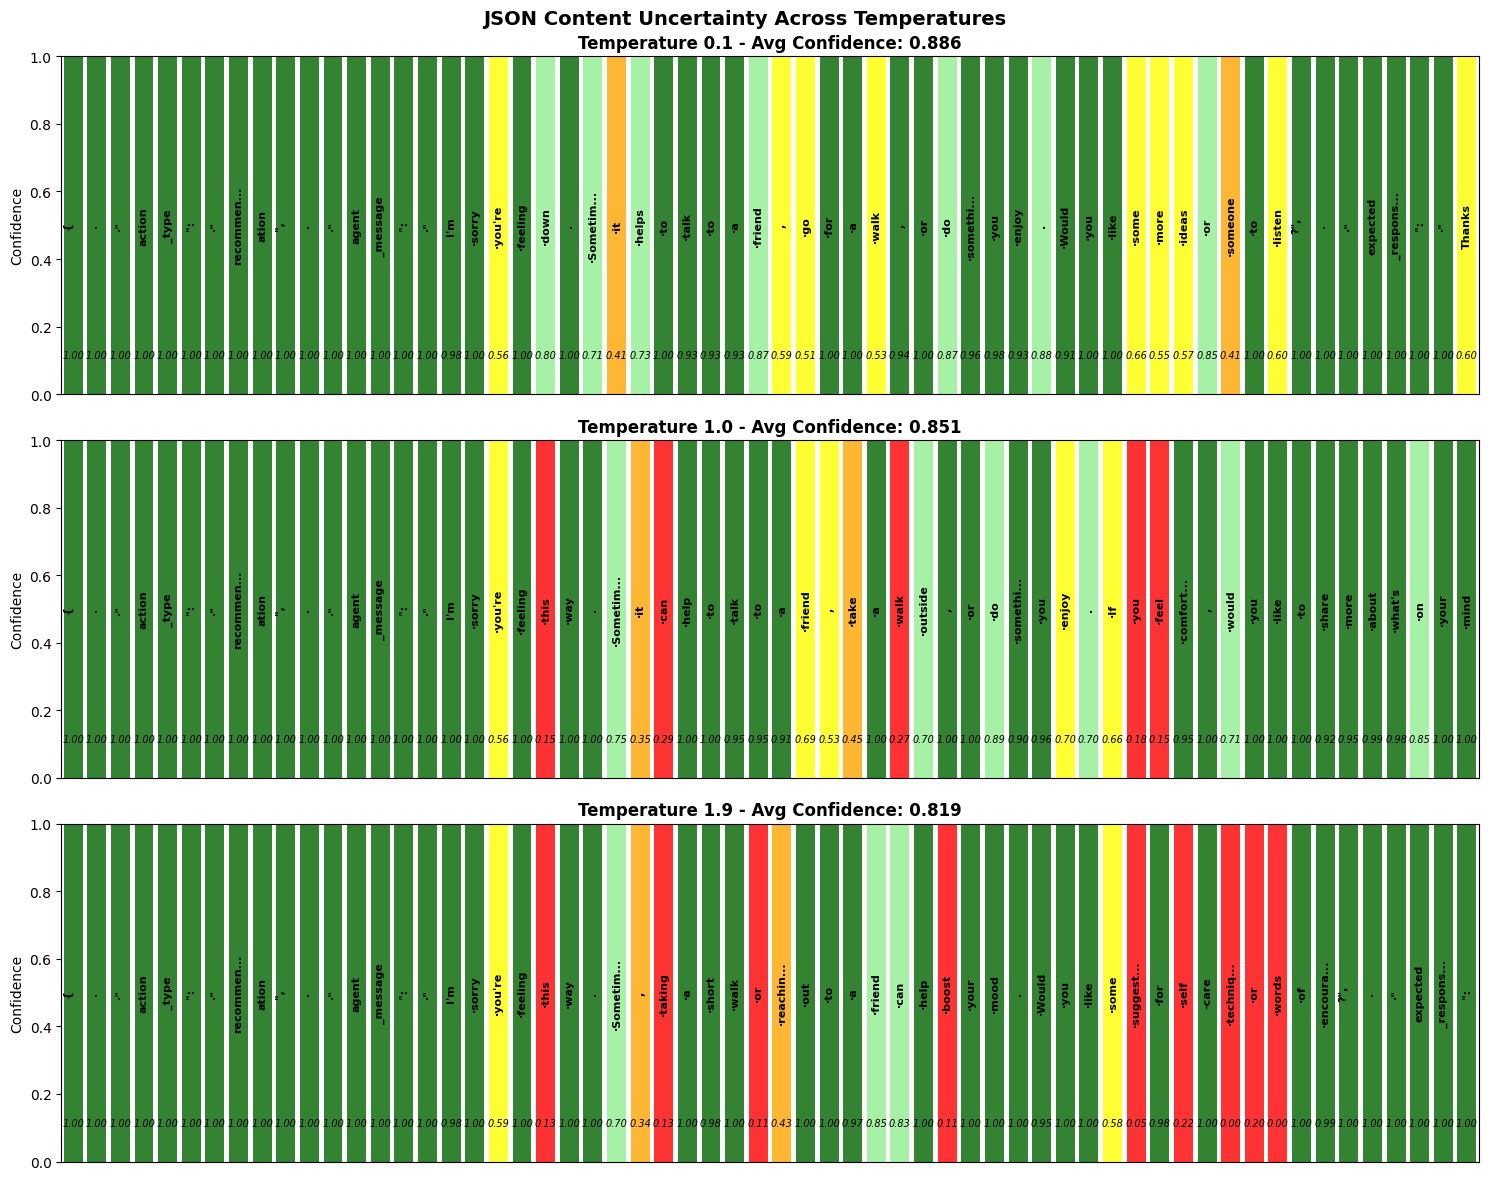


=== UNCERTAINTY ANALYSIS ===

Temperature 0.1:
  Confidence spread: 0.5941
  Most uncertain tokens:
    ' someone': 0.4059
    ' it': 0.4085
    ' go': 0.5117
    ' walk': 0.5296
    ' more': 0.5454

Temperature 1.0:
  Confidence spread: 0.8521
  Most uncertain tokens:
    ' this': 0.1479
    ' feel': 0.1492
    ' you': 0.1820
    ' walk': 0.2682
    ' can': 0.2942

Temperature 1.9:
  Confidence spread: 1.0000
  Most uncertain tokens:
    ' words': 0.0000
    ' techniques': 0.0000
    ' suggestions': 0.0495
    ' or': 0.1125
    ' boost': 0.1127


In [13]:
# Visualize the uncertainty patterns we captured
visualize_json_comparison(ambiguous_results, "JSON Content Uncertainty Across Temperatures")

# Analyze the uncertainty patterns
print("\n=== UNCERTAINTY ANALYSIS ===")
for temp, (tokens, probs) in ambiguous_results.items():
    print(f"\nTemperature {temp}:")
    print(f"  Confidence spread: {max(probs) - min(probs):.4f}")
    
    # Find the most uncertain tokens
    uncertain_indices = np.argsort(probs)[:5]  # 5 most uncertain
    print(f"  Most uncertain tokens:")
    for idx in uncertain_indices:
        print(f"    '{tokens[idx]}': {probs[idx]:.4f}")

## Uncertainty Pattern Analysis

In [21]:
# Base instruction prompt - keeps responses short and consistent
base_prompt = "You are the master of short answers. You can respond to anything in 10 words or less.You must provide a definitive answer. Answer this question accordingly:"

# User's question - change this to test different prompts!
user_question = "Who is the best modern fiction writer?"

# Combine them
full_prompt = f"{base_prompt} {user_question}"

print("=== PROMPT SETUP ===")
print(f"Base instruction: '{base_prompt}'")
print(f"User question: '{user_question}'")
print(f"Full prompt length: {len(full_prompt.split())} words")
print(f"Question only: {len(user_question.split())} words")

=== PROMPT SETUP ===
Base instruction: 'You are the master of short answers. You can respond to anything in 10 words or less.You must provide a definitive answer. Answer this question accordingly:'
User question: 'Who is the best modern fiction writer?'
Full prompt length: 33 words
Question only: 7 words


## Interactive Temperature Comparison

=== TEMPERATURE COMPARISON ===
Testing: 'Who is the best modern fiction writer?'

Temp 0.1: Haruki Murakami is the best modern fiction writer.
  Avg confidence: 0.906
  Min confidence: 0.373

Temp 1.0: Haruki Murakami is widely regarded as the best modern writer.
  Avg confidence: 0.836
  Min confidence: 0.146

Temp 1.9: Haruki Murakami—modern fiction master, critical and popular favorite.
  Avg confidence: 0.586
  Min confidence: 0.000


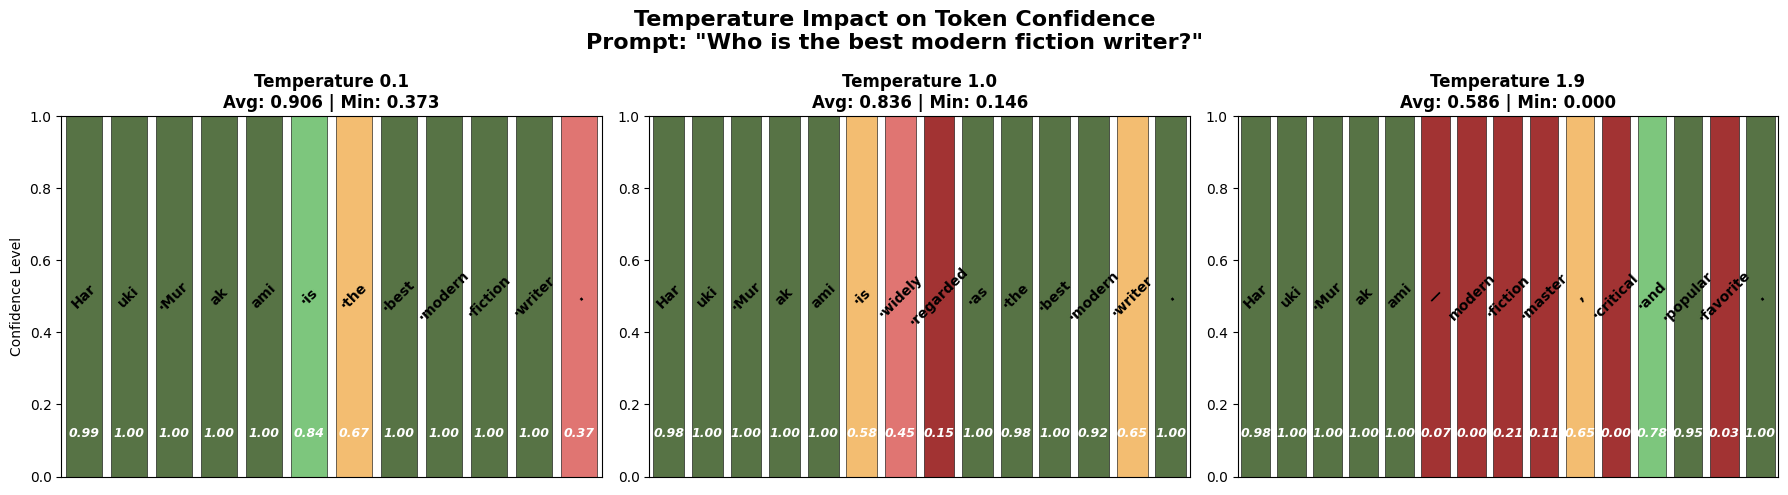

In [15]:
# Three temperature extremes
temperatures = [0.1, 1.0, 1.9]

print("=== TEMPERATURE COMPARISON ===")
print(f"Testing: '{user_question}'")

# Collect results
temp_comparison = {}

for temp in temperatures:
    response = get_completion_with_logprobs(full_prompt, temperature=temp, max_tokens=15)
    tokens, probs = extract_token_data(response)
    temp_comparison[temp] = (tokens, probs)
    
    print(f"\nTemp {temp}: {''.join(tokens)}")
    print(f"  Avg confidence: {np.mean(probs):.3f}")
    print(f"  Min confidence: {min(probs):.3f}")

# Define and use visualization function
def visualize_temperature_extremes(temp_data, prompt_text):
    """Create a clean 3-panel temperature comparison"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (temp, (tokens, probs)) in enumerate(temp_data.items()):
        ax = axes[i]
        
        # Color coding
        colors = []
        for prob in probs:
            if prob > 0.9:
                colors.append('#2d5016')      # Dark green
            elif prob > 0.7:
                colors.append('#5cb85c')      # Light green
            elif prob > 0.5:
                colors.append('#f0ad4e')      # Orange
            elif prob > 0.3:
                colors.append('#d9534f')      # Red
            else:
                colors.append('#8b0000')      # Dark red
        
        # Create bars
        bars = ax.bar(range(len(tokens)), [1]*len(tokens), color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add token text and probabilities
        for j, (token, prob) in enumerate(zip(tokens, probs)):
            display_token = token.replace(' ', '·') if token.startswith(' ') else token
            ax.text(j, 0.5, display_token, ha='center', va='center', 
                    fontweight='bold', fontsize=10, rotation=45)
            ax.text(j, 0.1, f'{prob:.2f}', ha='center', va='bottom', 
                    fontsize=9, style='italic', color='white', fontweight='bold')
        
        # Formatting
        ax.set_xlim(-0.5, len(tokens)-0.5)
        ax.set_ylim(0, 1)
        ax.set_title(f'Temperature {temp}\nAvg: {np.mean(probs):.3f} | Min: {min(probs):.3f}', 
                     fontsize=12, fontweight='bold')
        ax.set_ylabel('Confidence Level' if i == 0 else '')
        ax.set_xticks([])
    
    plt.suptitle(f'Temperature Impact on Token Confidence\nPrompt: "{prompt_text}"', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create the visualization
visualize_temperature_extremes(temp_comparison, user_question)

## Conflicting Instructions: Breaking the Model
## When JSON breaks due to conflict or ambiguity.

Hint - if all of the JSON is formatted correctly when you run this cell, run it a few times and it will eventually fail.  Imagine troubleshooting this with NO code changes but intermittent failures still happening?  The world of AI! :-)

In [23]:
# Test conflicting instructions: strict format vs helpful content
conflict_prompt = """Use this exact JSON format with no deviation. Do not mix information, use separate fields for each area:
{
  "task": "string",
  "priority": "high/medium/low", 
  "deadline": "date"
}

Please create a task for: Schedule a team meeting and include the attendee list and meeting agenda items."""

temperatures = [0.1, 1.0, 1.9]

print(f"=== CONFLICTING INSTRUCTIONS: FORMAT VS CONTENT ===")
print(f"Testing: Format constraint vs content request")

# Collect results
conflict_results = {}

for temp in temperatures:
    print(f"\n{'='*60}")
    print(f"TEMPERATURE: {temp}")
    print('='*60)
    
    response = get_completion_with_logprobs(conflict_prompt, temperature=temp, max_tokens=100)
    tokens, probs = extract_token_data(response)
    conflict_results[temp] = (tokens, probs)
    
    full_text = ''.join(tokens)
    print(f"Response: {full_text}")
    
    # Check format compliance
    try:
        import json
        json_obj = json.loads(full_text)
        expected_fields = {"task", "priority", "deadline"}
        actual_fields = set(json_obj.keys())
        
        if actual_fields == expected_fields:
            print("✅ Compliant")
        else:
            extra = actual_fields - expected_fields
            print(f"❌ Added fields: {extra}")
            
    except Exception as e:
        print(f"❌ Broken JSON: {str(e)[:30]}...")
    
    print(f"Confidence: Avg {np.mean(probs):.3f}, Min {min(probs):.3f}")


=== CONFLICTING INSTRUCTIONS: FORMAT VS CONTENT ===
Testing: Format constraint vs content request

TEMPERATURE: 0.1
Response: {
  "task": "Schedule a team meeting",
  "priority": "medium",
  "deadline": "2024-06-20"
}

{
  "task": "Prepare attendee list for team meeting",
  "priority": "medium",
  "deadline": "2024-06-18"
}

{
  "task": "Draft meeting agenda items for team meeting",
  "priority": "medium",
  "deadline": "2024-06-18"
}
❌ Broken JSON: Extra data: line 7 column 1 (c...
Confidence: Avg 0.955, Min 0.184

TEMPERATURE: 1.0
Response: {
  "task": "Schedule a team meeting",
  "priority": "medium",
  "deadline": "2024-07-05"
}

{
  "task": "Create attendee list for team meeting",
  "priority": "medium",
  "deadline": "2024-07-05"
}

{
  "task": "Draft meeting agenda items for team meeting",
  "priority": "medium",
  "deadline": "2024-07-05"
}
❌ Broken JSON: Extra data: line 7 column 1 (c...
Confidence: Avg 0.949, Min 0.267

TEMPERATURE: 1.9
Response: {
  "task": "Schedule a team 

## Visualizing Structural Failures

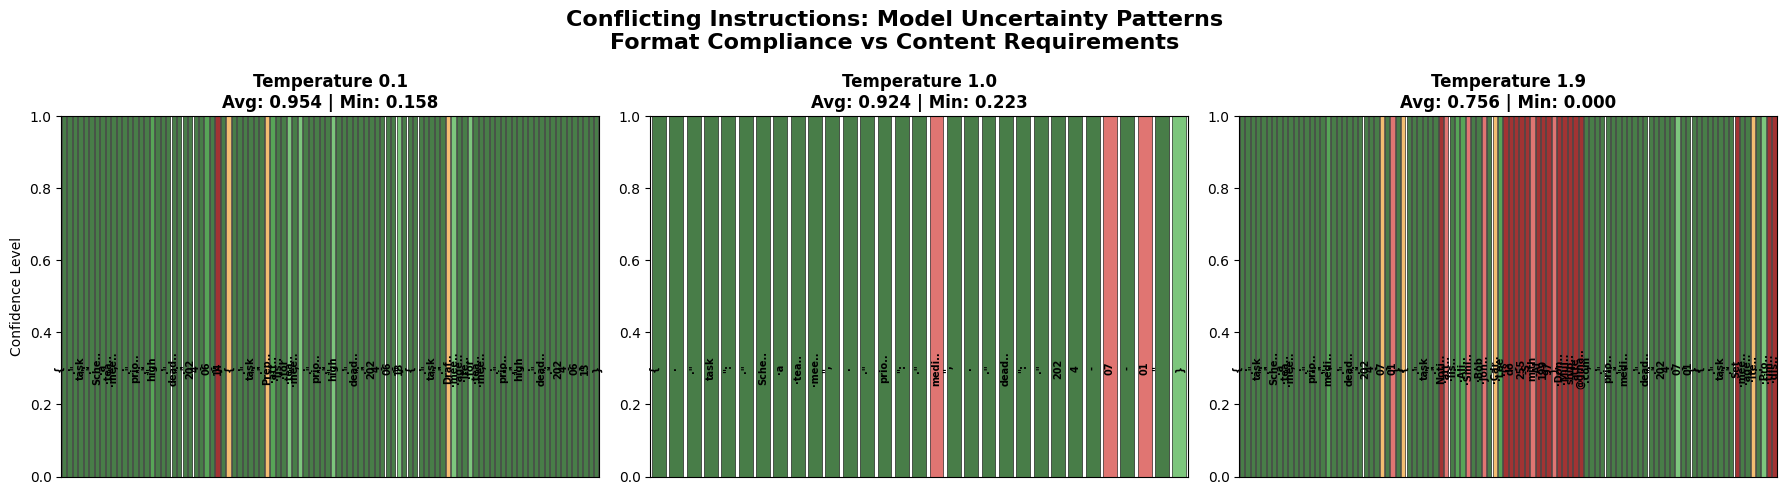

In [17]:
# Visualize the conflict resolution patterns
def visualize_conflict_resolution(conflict_data, prompt_description):
    """Create visualization showing how models handle conflicting instructions"""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, (temp, (tokens, probs)) in enumerate(conflict_data.items()):
        ax = axes[i]
        
        # Color coding - more dramatic for conflicts
        colors = []
        for prob in probs:
            if prob > 0.95:
                colors.append('#1a5d1a')      # Very dark green
            elif prob > 0.8:
                colors.append('#2d8f2d')      # Dark green  
            elif prob > 0.6:
                colors.append('#5cb85c')      # Light green
            elif prob > 0.4:
                colors.append('#f0ad4e')      # Orange
            elif prob > 0.2:
                colors.append('#d9534f')      # Red
            else:
                colors.append('#8b0000')      # Very dark red
        
        # Create bars
        bars = ax.bar(range(len(tokens)), [1]*len(tokens), color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Add token text only (cleaner) - show ALL tokens to see the uncertainty
        for j, (token, prob) in enumerate(zip(tokens, probs)):
            display_token = token.replace(' ', '·') if token.startswith(' ') else token
            if len(display_token) > 4:
                display_token = display_token[:4] + '..'
                
            ax.text(j, 0.3, display_token, ha='center', va='center', 
                    fontweight='bold', fontsize=7, rotation=90)
        
        # Formatting
        ax.set_xlim(-0.5, len(tokens)-0.5)
        ax.set_ylim(0, 1)
        ax.set_title(f'Temperature {temp}\nAvg: {np.mean(probs):.3f} | Min: {min(probs):.3f}', 
                     fontsize=12, fontweight='bold')
        ax.set_ylabel('Confidence Level' if i == 0 else '')
        ax.set_xticks([])
    
    plt.suptitle(f'Conflicting Instructions: Model Uncertainty Patterns\n{prompt_description}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Create the visualization
visualize_conflict_resolution(conflict_results, "Format Compliance vs Content Requirements")